In [19]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
# from CGAN import loaddata, D, G
from matplotlib import pyplot as plt
from torchvision.utils import make_grid, save_image
from typing import Union

Auxiliary functions for displaying images ディスプレイ画像の補助関数

In [2]:
def showimg(img: torch.Tensor, mean: Union[int, float, tuple], std: Union[int, float, tuple], cmap: str = 'magma'):
    """
    Show the image
    画像を表示
    """
    if isinstance(mean, tuple):
        inv_img = torch.stack([img[chnl] * std[chnl] + mean[chnl] for chnl in range(len(mean))])#each channel is reverse standardized separately
    else:
        inv_img = torch.stack([img[0] * std + mean])#each channel is reverse standardized separately
    plt.imshow(torch.permute(inv_img.cpu(), (1, 2, 0)), cmap = cmap)#restore to (H X W X C) format
    plt.axis('off')
    plt.show()

Parameters pre-setting 事前のパラメータ設定

In [15]:
noise_len = 100#length of noise input
batch_size = 256#batch size
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')#use GPU or CPU
print(torch.cuda.is_available())#is the GPU available

False


Test set テストセット

In [16]:
norm_trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])#normalize images
testset = ImageFolder('./artbench-10-imagefolder-split/test', transform = norm_trans)
test_loader = DataLoader(testset, batch_size = batch_size, shuffle = True, pin_memory = torch.cuda.is_available())

In [24]:
class D(nn.Module):
    """
    Discriminator of Convolutional Generative Adversarial Network
    コンボリューション生成対抗ネットワークの識別器
    """
    def __init__(self):
        """
        Initialization
        初期化
        """
        super(D, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size = 13, stride = 3, bias = False)
        self.conv2 = nn.Conv2d(6, 9, kernel_size = 7, stride = 3, bias = False)
        self.conv3 = nn.Conv2d(9, 12, kernel_size = 5, stride = 3, bias = False)
        self.conv4 = nn.Conv2d(12, 15, kernel_size = 5, stride = 1, bias = False)
        self.linear = nn.Linear(240, 1)
        self.norm1 = nn.BatchNorm2d(6)
        self.norm2 = nn.BatchNorm2d(9)
        self.norm3 = nn.BatchNorm2d(12)
        self.norm4 = nn.BatchNorm2d(15)
        self.activation = nn.LeakyReLU(0.2)
        self.dropout = nn.Dropout(0.2)

    def forward(self, input: torch.Tensor):#[batch_size, 3, 256, 256]
        """
        Forward propagation
        フォワード伝播
        """
        output = self.dropout(self.activation(self.norm1(self.conv1(input))))#[batch_size, 6, 82, 82],82=(256-13)/3+1
        output = self.dropout(self.activation(self.norm2(self.conv2(output))))#[batch_size, 9, 26, 26],26=(82-7)/3+1
        output = self.dropout(self.activation(self.norm3(self.conv3(output))))#[batch_size, 12, 8, 8],8=(26-5)/3+1
        output = self.dropout(self.activation(self.norm4(self.conv4(output))))#[batch_size, 15, 4, 4],4=(8-5)/1+1
        output = output.reshape(-1, 240)#[batch_size, 240],240=15X4X4
        output = self.activation(self.linear(output)).reshape(-1)#[batch_size]

        return output

    def init_model(self):
        """
        Model initialization
        モデル初期化
        """
        for name, layer in self._modules.items():
            if name in ('conv1', 'conv2', 'conv3'):
                nn.init.kaiming_normal_(layer.weight, mode = 'fan_in', nonlinearity = 'leaky_relu')
            elif name == 'conv4':
                nn.init.kaiming_normal_(layer.weight, mode = 'fan_out', nonlinearity = 'leaky_relu')
            elif isinstance(layer, nn.BatchNorm2d):
                nn.init.constant_(layer.weight, 1.)
                nn.init.constant_(layer.bias, 0.)
            elif isinstance(layer, nn.Linear):
                nn.init.normal_(layer.weight, std = 0.01)
                nn.init.normal_(layer.bias, std = 0.01)

    def loadparam(self, path: str):
        """
        Load pre-saved model parameters
        ロード前に保存したモデルパラメータ
        """
        self.load_state_dict(torch.load(path, map_location = torch.device('cpu')))

    def savemodel(self, path: str = './Discriminator.pth'):
        """
        Save the trained model
        訓練されたモデルを保存する
        """
        torch.save(self.state_dict(), path)

    def showparam(self):
        """
        Show model parameters
        モデルパラメータの表示
        """
        return [(name, param) for name, param in self.named_parameters()]

In [23]:
class G(nn.Module):
    """
    Generator of Convolutional Generative Adversarial Network
    コンボリューション生成対抗ネットワークの生成器
    """
    def __init__(self):
        """
        Initialization
        初期化
        """
        super(G, self).__init__()
        self.t_conv1 = nn.ConvTranspose2d(15, 12, kernel_size = 5, stride = 1, bias = False)
        self.t_conv2 = nn.ConvTranspose2d(12, 9, kernel_size = 5, stride = 3, bias = False)
        self.t_conv3 = nn.ConvTranspose2d(9, 6, kernel_size = 7, stride = 3, bias = False)
        self.t_conv4 = nn.ConvTranspose2d(6, 3, kernel_size = 13, stride = 3, bias = False)
        self.linear = nn.Linear(100, 240)
        self.activation = nn.LeakyReLU(0.2)
        self.norm1 = nn.BatchNorm2d(12)
        self.norm2 = nn.BatchNorm2d(9)
        self.norm3 = nn.BatchNorm2d(6)
        self.norm4 = nn.BatchNorm2d(3)
        self.tanh = nn.Tanh()

    def forward(self, input: torch.Tensor):#[batch_size, 100]
        """
        Forward propagation
        フォワード伝播
        """
        output = self.activation(self.linear(input))#[batch_size, 240]
        output = output.reshape(-1, 15, 4, 4)#[batch_size, 15, 4, 4]其中240=15X4X4
        output = self.activation(self.norm1(self.t_conv1(output)))#[batch_size, 15, 8, 8]
        output = self.activation(self.norm2(self.t_conv2(output)))#[batch_size, 9, 26, 26]
        output = self.activation(self.norm3(self.t_conv3(output)))#[batch_size, 6, 82, 82]
        output = self.activation(self.norm4(self.t_conv4(output)))#[batch_size, 3, 256, 256]
        output = self.tanh(output)#[batch_size, 3, 256, 256]

        return output

    def init_model(self):
        """
        Model initialization
        モデル初期化
        """
        for name, layer in self._modules.items():
            if name in ('t_conv1', 't_conv2', 't_conv3'):
                nn.init.kaiming_normal_(layer.weight, mode = 'fan_in', nonlinearity = 'leaky_relu')
            elif name == 't_conv4':
                nn.init.kaiming_normal_(layer.weight, mode = 'fan_out', nonlinearity = 'leaky_relu')
            elif isinstance(layer, nn.BatchNorm2d):
                nn.init.constant_(layer.weight, 1.)
                nn.init.constant_(layer.bias, 0.)
            elif isinstance(layer, nn.Linear):
                nn.init.normal_(layer.weight, std = 0.01)
                nn.init.normal_(layer.bias, std = 0.01)

    def loadparam(self, path: str):
        """
        Load pre-saved model parameters
        ロード前に保存したモデルパラメータ
        """
        self.load_state_dict(torch.load(path, map_location = torch.device('cpu')))

    def savemodel(self, path: str = './Generator.pth'):
        """
        Save the trained model
        訓練されたモデルを保存する
        """
        torch.save(self.state_dict(), path)

    def showparam(self):
        """
        Show model parameters
        モデルパラメータの表示
        """
        return [(name, param) for name, param in self.named_parameters()]

In [25]:
disc = D().to(device)#create a new model instance
gen = G().to(device)#create a new model instance

Load pre-saved model parameters ロード前に保存したモデルパラメータ

In [10]:
disc = D().to(device)#create a new model instance
disc.loadparam('./Discriminator.pth')#load previously saved model parameters
gen = G().to(device)#create a new model instance
gen.loadparam('./Generator.pth')#load previously saved model parameters

Test テスト

real labels of a batch in testset:
 tensor([5, 2, 8, 5, 8, 2, 5, 9, 0, 7, 7, 2, 2, 3, 5, 8, 9, 6, 3, 6, 1, 7, 2, 8,
        9, 1, 5, 4, 8, 8, 2, 2, 5, 8, 4, 8, 3, 2, 8, 1, 2, 4, 3, 5, 8, 7, 1, 6,
        8, 6, 6, 6, 8, 5, 4, 5, 9, 0, 4, 2, 9, 8, 0, 9])


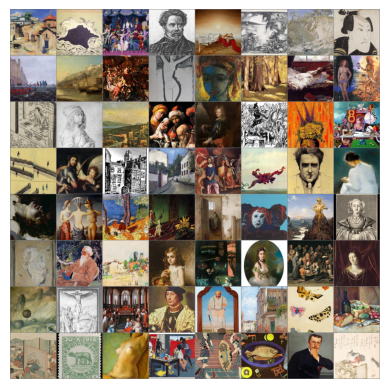

In [17]:
iter_test = iter(test_loader)
test_imgs, test_lbs = next(iter_test)
print('real labels of a batch in testset:\n', test_lbs)

showimg(make_grid(test_imgs, 16), (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

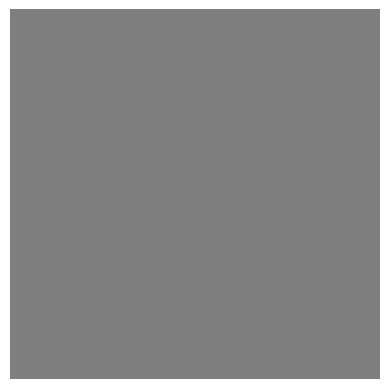

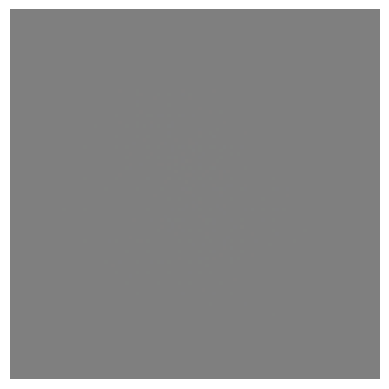

In [26]:
disc.eval()
gen.eval()
# torch.manual_seed(0)
noise = torch.randn(batch_size, noise_len).to(device)#generated nosie input
showimg(make_grid(gen(noise).detach(), 16), (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))#A batch of images
showimg(make_grid(gen(noise).to(device).detach()[0], 1), (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))#single image
# save_image(make_grid(gen(noise).detach(), 16), './generated_images.png')#save generated images